<a href="https://colab.research.google.com/github/Bennnnur-dev/pytorch/blob/main/02_nn_classification_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MAKE DATA AND GET IT READY

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles

X, y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 samples of X: \n {X[:5]}")
print(f"First 5 samples of y: \n {y[:5]}")

First 5 samples of X: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: 
 [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


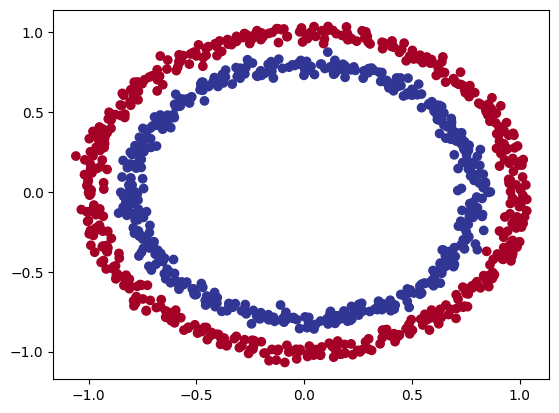

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [ ]:
# View the first example of features and labels

X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [ ]:
# Turn data into tensors and create train and test splits

import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
# Split data into training and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42) # 20% of data will be test & 80% will be train


MODEL

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self._layer_1(x))

model_0 = CircleModelV1().to(device)

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

MAKE PREDICTIONS

In [ ]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6653,  0.6582],
                      [-0.3515, -0.6461],
                      [-0.4377,  0.1175],
                      [ 0.6063, -0.5226],
                      [ 0.1608, -0.6145]], device='cuda:0')),
             ('0.bias',
              tensor([-0.1263,  0.4605, -0.5638, -0.2737, -0.2118], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1187, -0.2365, -0.2350,  0.4020,  0.3985]], device='cuda:0')),
             ('1.bias', tensor([-0.0422], device='cuda:0'))])

LOSS FN & OPTIMIZER

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

# accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred) * 100
  return acc

LOGITS --> PROBABILITIES --> LABELS

In [ ]:
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[-0.6321],
        [-0.5832],
        [-0.3612],
        [-0.7105],
        [ 0.2723]], device='cuda:0')

In [ ]:
# use the sigmoid activation function --> probabilities
y_preds_probs = torch.sigmoid(y_logits)

with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

TRAINING / TESTING LOOP

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # train
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_labels = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_labels)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # test
  model_0.eval()
  with torch.inference_mode():
    y_logits_test = model_0(X_test).squeeze()
    y_labels_test = torch.round(torch.sigmoid(y_logits_test))

    test_loss = loss_fn(y_logits_test, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=y_labels_test)

    if epoch % 10 == 0: # each 10 epoch
      print(f"Epoch: {epoch} | Train loss: {loss: 4f} - Train acc: {acc: 2f} | Test loss: {test_loss: 4f} - Test acc: {test_acc: 2f}")


Epoch: 0 | Train loss:  0.716360 - Train acc:  48.750000 | Test loss:  0.710455 - Test acc:  47.500000
Epoch: 10 | Train loss:  0.715343 - Train acc:  48.750000 | Test loss:  0.709521 - Test acc:  48.000000
Epoch: 20 | Train loss:  0.714392 - Train acc:  48.750000 | Test loss:  0.708654 - Test acc:  48.000000
Epoch: 30 | Train loss:  0.713501 - Train acc:  49.000000 | Test loss:  0.707849 - Test acc:  48.000000
Epoch: 40 | Train loss:  0.712664 - Train acc:  48.750000 | Test loss:  0.707100 - Test acc:  48.000000
Epoch: 50 | Train loss:  0.711878 - Train acc:  48.750000 | Test loss:  0.706403 - Test acc:  48.000000
Epoch: 60 | Train loss:  0.711138 - Train acc:  48.750000 | Test loss:  0.705754 - Test acc:  48.000000
Epoch: 70 | Train loss:  0.710441 - Train acc:  48.500000 | Test loss:  0.705148 - Test acc:  48.000000
Epoch: 80 | Train loss:  0.709783 - Train acc:  48.625000 | Test loss:  0.704581 - Test acc:  48.000000
Epoch: 90 | Train loss:  0.709162 - Train acc:  48.500000 | Test 

VISUALIZE

In [40]:
import requests
from pathlib import Path

# download helper fn from Learn Pytorch repo
if Path("helper_function.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

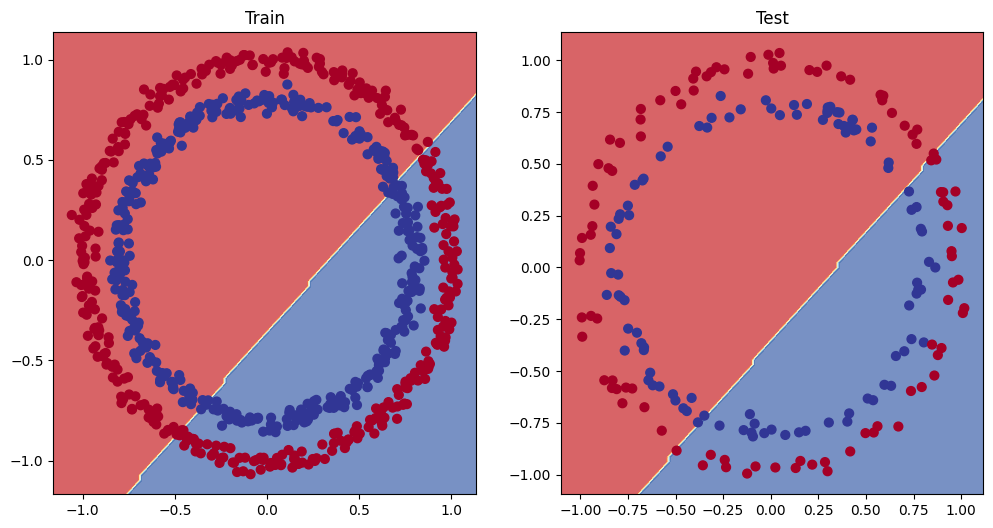

In [ ]:
# Plot decision boundary of the model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

IMPROVE MODEL

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_2(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

epoch = 1000

torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in range(epochs):
  # train
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_labels = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_labels)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  # test
  model_1.eval()
  with torch.inference_mode():
    y_logits_test = model_1(X_test).squeeze()
    y_labels_test = torch.round(torch.sigmoid(y_logits_test))

    test_loss = loss_fn(y_logits_test, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=y_labels_test)

    if epoch % 10 == 0: # each 10 epoch
      print(f"Epoch: {epoch} | Train loss: {loss: 4f} - Train acc: {acc: 2f} | Test loss: {test_loss: 4f} - Test acc: {test_acc: 2f}")


Epoch: 0 | Train loss:  0.693955 - Train acc:  50.875000 | Test loss:  0.692615 - Test acc:  51.000000
Epoch: 10 | Train loss:  0.693688 - Train acc:  50.250000 | Test loss:  0.692704 - Test acc:  50.000000
Epoch: 20 | Train loss:  0.693512 - Train acc:  50.125000 | Test loss:  0.692830 - Test acc:  49.500000
Epoch: 30 | Train loss:  0.693386 - Train acc:  50.500000 | Test loss:  0.692966 - Test acc:  48.000000
Epoch: 40 | Train loss:  0.693292 - Train acc:  50.375000 | Test loss:  0.693103 - Test acc:  49.000000
Epoch: 50 | Train loss:  0.693220 - Train acc:  49.875000 | Test loss:  0.693236 - Test acc:  50.000000
Epoch: 60 | Train loss:  0.693166 - Train acc:  49.375000 | Test loss:  0.693362 - Test acc:  51.500000
Epoch: 70 | Train loss:  0.693124 - Train acc:  49.375000 | Test loss:  0.693481 - Test acc:  50.500000
Epoch: 80 | Train loss:  0.693092 - Train acc:  50.125000 | Test loss:  0.693593 - Test acc:  50.000000
Epoch: 90 | Train loss:  0.693067 - Train acc:  50.500000 | Test 

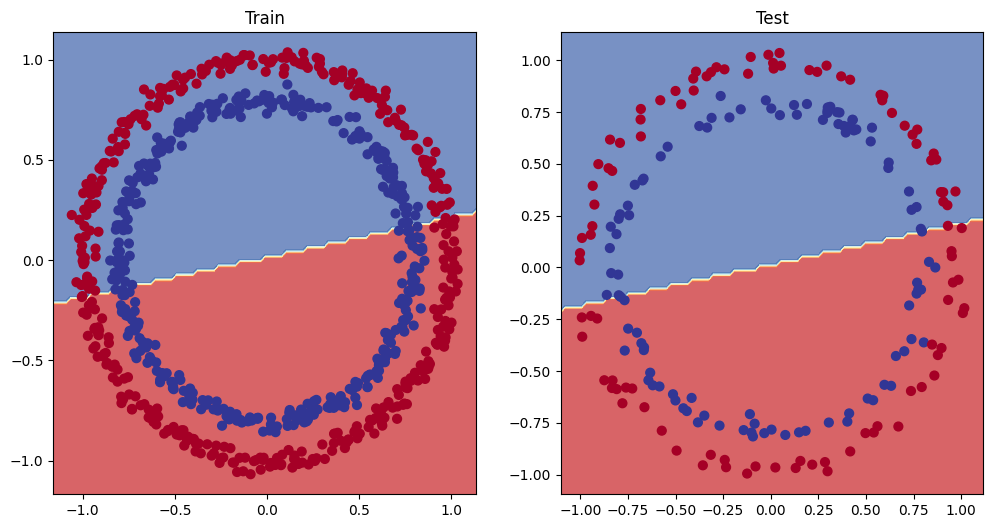

In [ ]:
# Plot decision boundary of the model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [ ]:
# create some data

weight = 0.7
bias = 0.3

X_regression = torch.arange(0, 1, 0.01).unsqueeze(1).to(device)
y_regression = weight * X_regression + bias

split = int(len(X_regression) * 0.8)

X_train_regression, y_train_regression = X_regression[:split], y_regression[:split]
X_test_regression, y_test_regression = X_regression[split:], y_regression[split:]

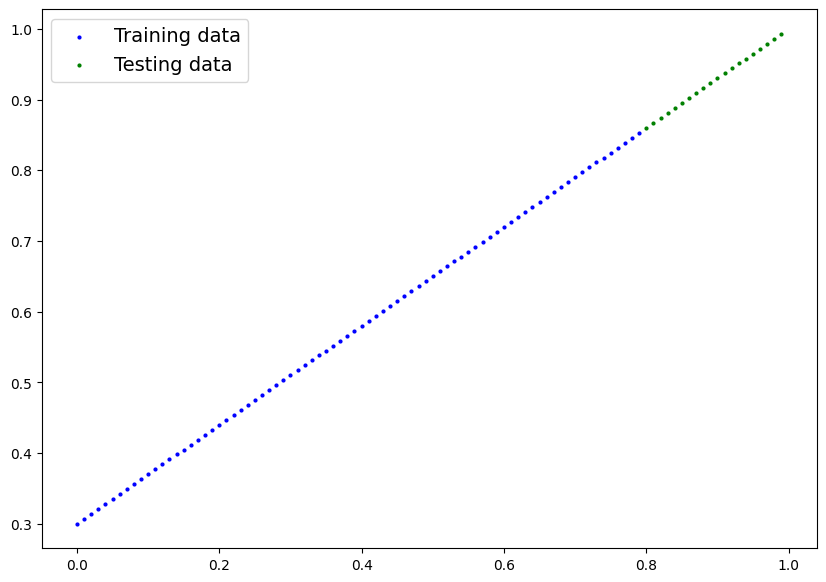

In [ ]:
plot_predictions(train_data=X_train_regression.to("cpu"),
                 train_labels=y_train_regression.to("cpu"),
                 test_data=X_test_regression.to("cpu"),
                 test_labels=y_test_regression.to("cpu"))

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .5f} | Test loss: {test_loss: .5f}")

Epoch: 0 | Loss:  0.75986 | Test loss:  0.91103
Epoch: 100 | Loss:  0.02858 | Test loss:  0.00081
Epoch: 200 | Loss:  0.02533 | Test loss:  0.00209
Epoch: 300 | Loss:  0.02137 | Test loss:  0.00305
Epoch: 400 | Loss:  0.01964 | Test loss:  0.00341
Epoch: 500 | Loss:  0.01940 | Test loss:  0.00387
Epoch: 600 | Loss:  0.01903 | Test loss:  0.00379
Epoch: 700 | Loss:  0.01878 | Test loss:  0.00381
Epoch: 800 | Loss:  0.01840 | Test loss:  0.00329
Epoch: 900 | Loss:  0.01798 | Test loss:  0.00360


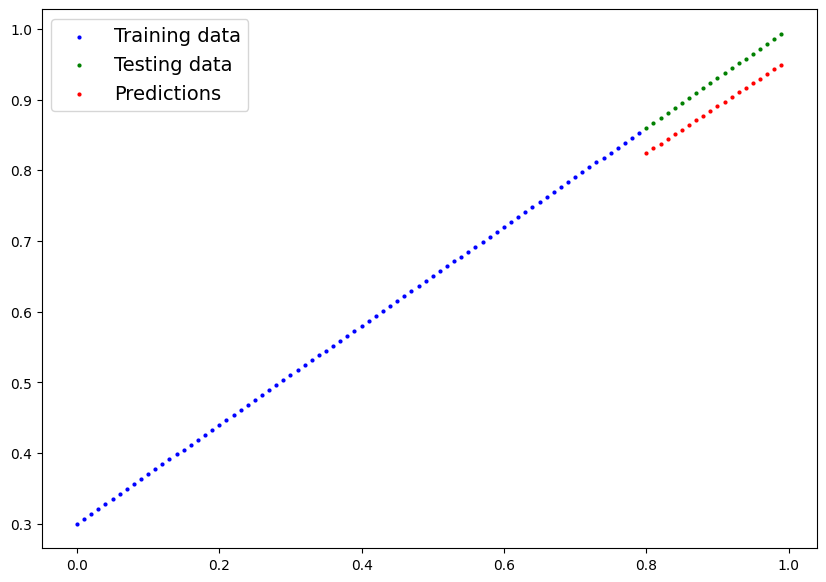

In [ ]:
model_2.eval()

with torch.inference_mode():
  preds_new = model_2(X_test_regression).to("cpu")

  plot_predictions(train_data=X_train_regression.to("cpu"),
                   train_labels=y_train_regression.to("cpu"),
                   test_data=X_test_regression.to("cpu"),
                   test_labels=y_test_regression.to("cpu"),
                   predictions=preds_new)

NON-LINEARITY

In [ ]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # non-linear

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

epochs = 3000

for epoch in range(epochs):
  ### train
  model_3.train()

  y_train_logits = model_3(X_train).squeeze()
  y_train_probs = torch.round(torch.sigmoid(y_train_logits))
  acc_train = accuracy_fn(y_true=y_train, y_pred=y_train_probs)

  loss_train = loss_fn(y_train_logits, y_train)
  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()

  ### test
  model_3.eval()
  with torch.inference_mode():
    y_test_logits = model_3(X_test).squeeze()
    loss_test = loss_fn(y_test_logits, y_test)
    y_test_probs = torch.round(torch.sigmoid(y_test_logits))
    acc_test = accuracy_fn(y_true=y_test, y_pred=y_test_probs)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss_train: 4f} - Train acc: {acc_train: 2f} | Test loss: {loss_test: 4f} - Test acc: {acc_test: 2f}")


Epoch: 0 | Train loss:  0.692946 - Train acc:  50.000000 | Test loss:  0.693188 - Test acc:  50.000000
Epoch: 100 | Train loss:  0.691153 - Train acc:  52.875000 | Test loss:  0.691024 - Test acc:  52.500000
Epoch: 200 | Train loss:  0.689774 - Train acc:  53.375000 | Test loss:  0.689396 - Test acc:  55.000000
Epoch: 300 | Train loss:  0.687949 - Train acc:  53.000000 | Test loss:  0.687232 - Test acc:  56.000000
Epoch: 400 | Train loss:  0.685168 - Train acc:  52.750000 | Test loss:  0.684115 - Test acc:  56.500000
Epoch: 500 | Train loss:  0.681022 - Train acc:  52.750000 | Test loss:  0.679412 - Test acc:  56.500000
Epoch: 600 | Train loss:  0.675149 - Train acc:  54.500000 | Test loss:  0.672851 - Test acc:  56.000000
Epoch: 700 | Train loss:  0.666589 - Train acc:  58.375000 | Test loss:  0.663216 - Test acc:  59.000000
Epoch: 800 | Train loss:  0.651596 - Train acc:  64.000000 | Test loss:  0.647569 - Test acc:  67.500000
Epoch: 900 | Train loss:  0.623623 - Train acc:  74.00000

In [ ]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

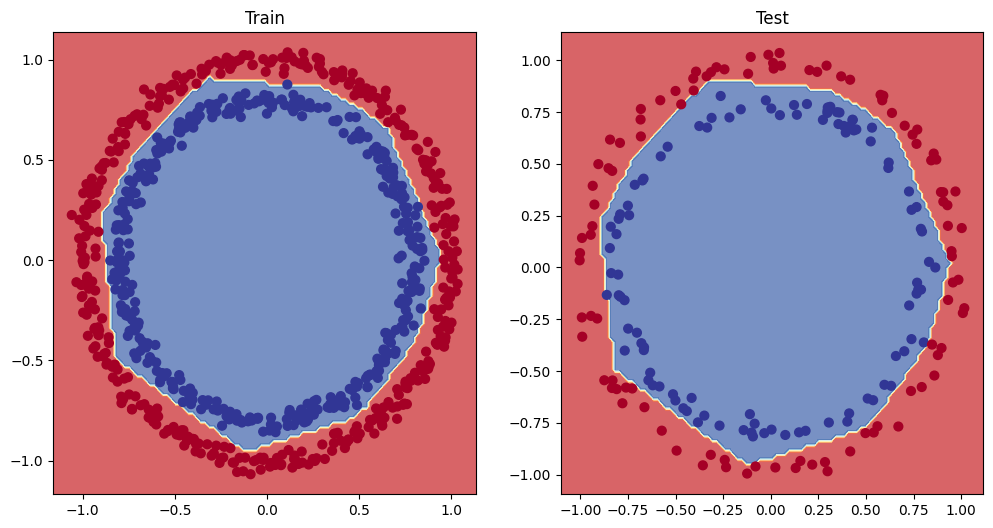

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

REPLICATING NON-LINEAR ACTIVATION FUNCTIONS

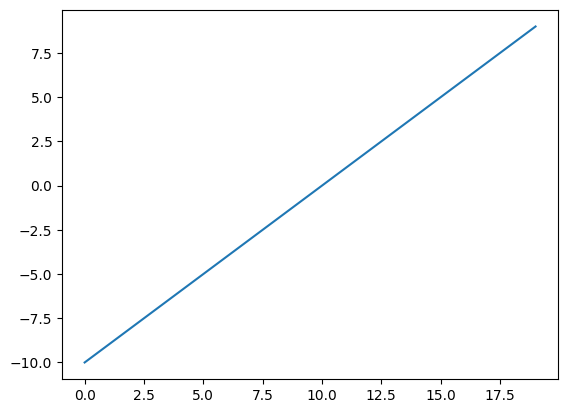

In [ ]:
A = torch.arange(-10, 10, 1, dtype=torch.float)

plt.plot(A)

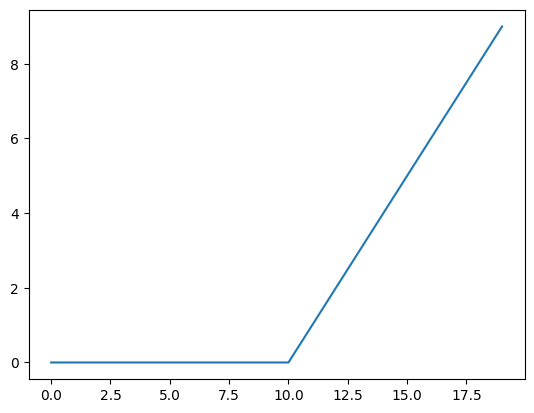

In [ ]:
plt.plot(torch.relu(A))

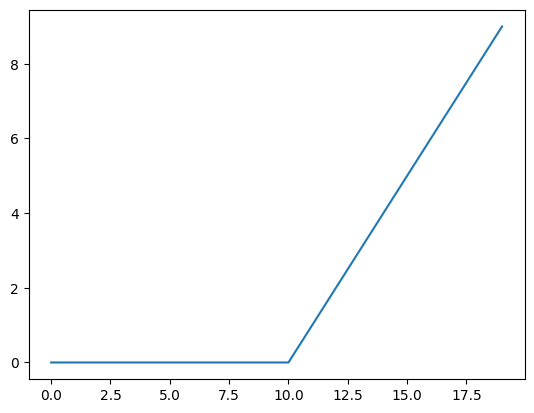

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x)

plt.plot(relu(A))

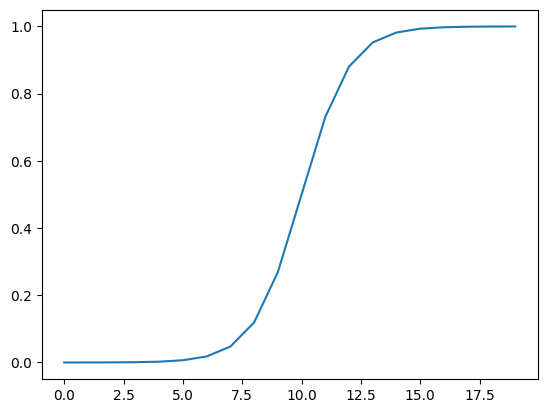

In [ ]:
plt.plot(torch.sigmoid(A))

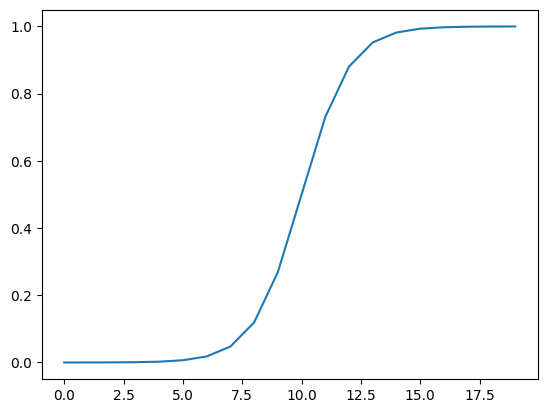

In [ ]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1/(1 + torch.e ** -x)

plt.plot(sigmoid(A))

MULTI-CLASS PROBLEM

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        [-6.0262, -4.4375],
        [-3.3397,  7.2175]], device='cuda:0', dtype=torch.float64) tensor([[ 4.6675,  4.4878],
        [-7.9969,  6.8803],
        [-6.2801, -7.8571],
        [ 3.6833,  1.1767],
        [-0.1404, 10.1654]], device='cuda:0', dtype=torch.float64) tensor([1, 0, 2, 2, 0], device='cuda:0') tensor([1, 3, 2, 1, 0], device='cuda:0') cuda:0


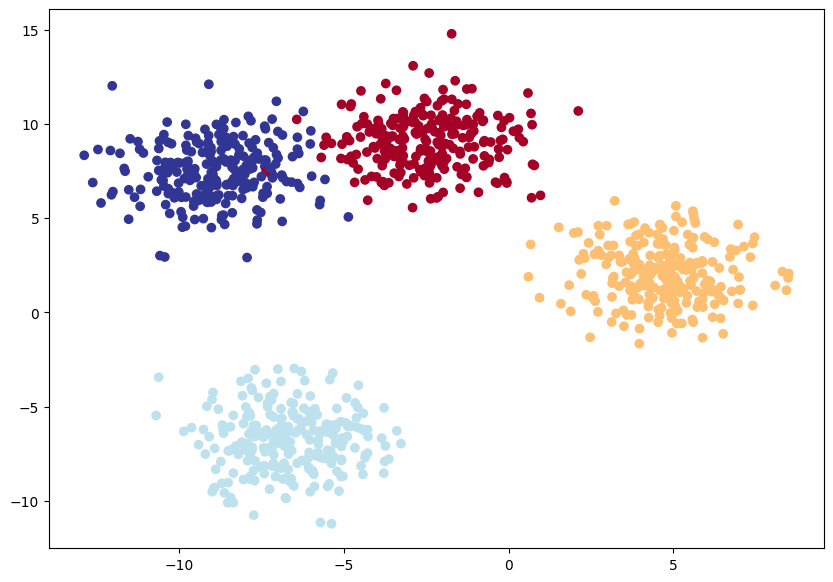

In [36]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).to(device)
y_blob = torch.from_numpy(y_blob).to(device)

X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)


print(X_train[:5], X_test[:5], y_train[:5], y_test[:5], X_train.device )

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0].cpu(), X_blob[:, 1].cpu(), c=y_blob.cpu(), cmap=plt.cm.RdYlBu)

In [38]:

### model

class MulticlassModel(nn.Module):
  def __init__(self, input_features: int, output_features: int, hidden_units: int = 8):
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

model_4 = MulticlassModel(input_features=2, output_features=4).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.01)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  model_4.train()

  train_logits = model_4(X_train.type(torch.float))
  train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

  train_loss = loss_fn(train_logits, y_train)

  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_test.type(torch.float))
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Train loss: {train_loss: 4f} | Test loss: {test_loss: 4f}")

Epoch: 0 | Train loss:  1.158827 | Test loss:  1.147240
Epoch: 100 | Train loss:  0.643822 | Test loss:  0.681170
Epoch: 200 | Train loss:  0.418915 | Test loss:  0.442279
Epoch: 300 | Train loss:  0.237404 | Test loss:  0.244546
Epoch: 400 | Train loss:  0.104329 | Test loss:  0.101476
Epoch: 500 | Train loss:  0.064820 | Test loss:  0.059139
Epoch: 600 | Train loss:  0.050314 | Test loss:  0.043546
Epoch: 700 | Train loss:  0.042891 | Test loss:  0.035380
Epoch: 800 | Train loss:  0.038328 | Test loss:  0.030225
Epoch: 900 | Train loss:  0.035267 | Test loss:  0.026901


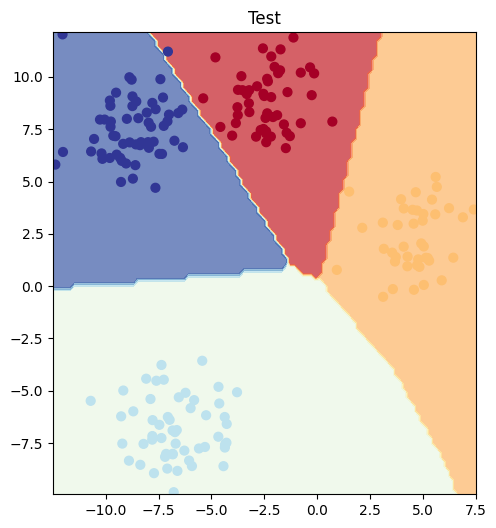

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test.type(torch.float), y_test)